In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
print(f"Python Version: {sys.version}")
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

Python Version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Tensorflow Version: 2.14.0


In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import zipfile
# zip_path = "/content/drive/MyDrive/Colab Notebooks/Brain MRI Dataset.zip"
# extract_path = "/content/drive/MyDrive/Colab Notebooks"

# with zipfile.ZipFile(zip_path, "r") as zip:
#   zip.extractall(extraction_path)

In [4]:
import os
data_path = "/content/drive/MyDrive/Colab Notebooks/Brain_Data_Organised"
data_directory = os.listdir(data_path)
data_directory

['Stroke', 'Normal']

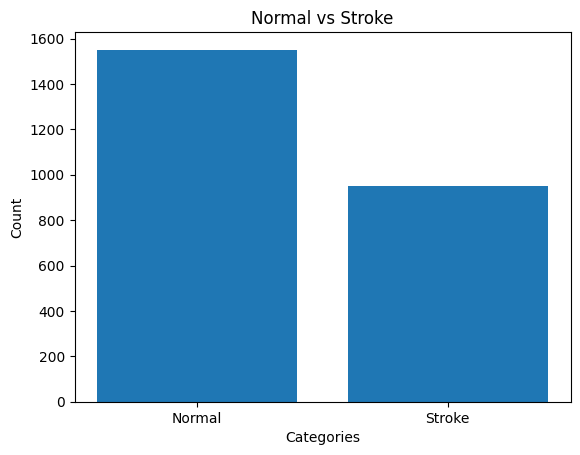

In [ ]:
normal_count = len(os.listdir(os.path.join(data_path, 'Normal')))
stroke_count = len(os.listdir(os.path.join(data_path, 'Stroke')))

plt.bar(['Normal', 'Stroke'], [normal_count, stroke_count])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Normal vs Stroke")
plt.show()

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = 224

def data_from_directory(data_directory):
  train_dataset = image_dataset_from_directory(
      data_directory,
      labels="inferred",
      label_mode="int",
      class_names=["Normal", "Stroke"],
      color_mode="grayscale",
      batch_size=16,
      image_size=(image_size, image_size),
      shuffle=True,
      seed=10,
      validation_split=0.2,
      subset="training",
      interpolation="bilinear",
  )

  test_dataset = image_dataset_from_directory(
      data_directory,
      labels="inferred",
      label_mode="int",
      class_names=["Normal", "Stroke"],
      color_mode="grayscale",
      batch_size=16,
      image_size=(image_size, image_size),
      shuffle=False,
      #seed=10,
      validation_split=0.2,
      subset="validation",
      interpolation="bilinear",
  )

  return train_dataset, test_dataset

train_ds, test_ds = data_from_directory(data_path)

Found 2501 files belonging to 2 classes.
Using 2001 files for training.
Found 2501 files belonging to 2 classes.
Using 500 files for validation.


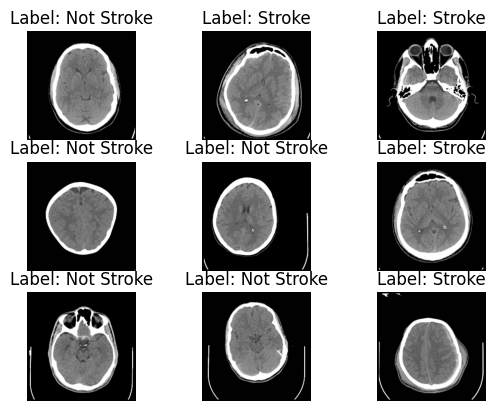

In [ ]:
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        label_text = "Stroke" if labels[i].numpy() == 1 else "Not Stroke"
        plt.title(f"Label: {label_text}")
        plt.axis('off')

plt.show()

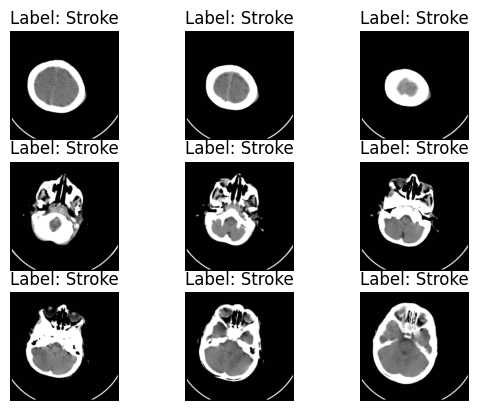

In [ ]:
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        label_text = "Stroke" if labels[i].numpy() == 1 else "Not Stroke"
        plt.title(f"Label: {label_text}")
        plt.axis('off')

plt.show()

In [ ]:
def data_preprocess(train_ds, test_ds):
  train_ds = train_ds.map(lambda x, y: (float(x)/255.0, y))
  train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  test_ds = test_ds.map(lambda x, y: (float(x)/255.0, y))
  test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_ds, test_ds

train_ds, test_ds = data_preprocess(train_ds, test_ds)

In [ ]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Custom NN Architecture

In [ ]:
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import BinaryCrossentropy

class MyModel(Model):
  def __init__(self, image_size, neuron=64):
    self.image_size = image_size
    super(MyModel, self).__init__()
    self.convolution_layer_1 = Conv2D(filters=64, kernel_size = (2,2), padding="valid",strides=(2, 2), activation=relu, input_shape=(image_size, image_size, 1))
    self.pooling_layer_1 = MaxPooling2D(pool_size=(2,2), padding="valid")
    self.convolution_layer_2 = Conv2D(filters=64, kernel_size=(2,2), padding="valid",strides=(2, 2), activation=relu)
    self.pooling_layer_2 = MaxPooling2D(pool_size = (2,2))
    self.flatten_layer = Flatten()
    self.dense_layer_1 = Dense(units=neuron, activation=relu)
    self.dropout_layer_1 = Dropout(0.2)
    self.dense_layer_2 = Dense(units=neuron, activation=relu)
    self.dropout_layer_2 = Dropout(0.2)
    self.output_layer = Dense(units=1, activation=sigmoid)

  def call(self, x):
    x = self.convolution_layer_1(x)
    x = self.pooling_layer_1(x)
    x = self.convolution_layer_2(x)
    x = self.pooling_layer_2(x)
    x = self.flatten_layer(x)
    x = self.dense_layer_1(x)
    x = self.dropout_layer_1(x)
    x = self.dense_layer_2(x)
    x = self.dropout_layer_2(x)
    output = self.output_layer(x)
    return output

  def summary(self):
    x = Input(shape=(self.image_size, self.image_size, 1))
    model = Model(inputs=x, outputs= self.call(x))
    model.summary()

model = MyModel(image_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor="val_loss", patience=3, )

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= BinaryCrossentropy(),
    metrics = ["accuracy"]
)

hist = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks = [callback],
    verbose=1,
)

Epoch 1/100
126/126 [==============================] - 216s 2s/step - loss: 0.6127 - accuracy: 0.6487 - val_loss: 0.5840 - val_accuracy: 0.7360
Epoch 2/100
126/126 [==============================] - 9s 66ms/step - loss: 0.3427 - accuracy: 0.8401 - val_loss: 0.3253 - val_accuracy: 0.8580
Epoch 3/100
126/126 [==============================] - 9s 70ms/step - loss: 0.1424 - accuracy: 0.9420 - val_loss: 0.1802 - val_accuracy: 0.9500
Epoch 4/100
126/126 [==============================] - 9s 66ms/step - loss: 0.0688 - accuracy: 0.9795 - val_loss: 0.0744 - val_accuracy: 0.9780
Epoch 5/100
126/126 [==============================] - 7s 55ms/step - loss: 0.0381 - accuracy: 0.9870 - val_loss: 0.0493 - val_accuracy: 0.9860
Epoch 6/100
126/126 [==============================] - 8s 62ms/step - loss: 0.0326 - accuracy: 0.9920 - val_loss: 0.0348 - val_accuracy: 0.9900
Epoch 7/100
126/126 [==============================] - 7s 54ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0550 - val_accuracy:

In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 1s 32ms/step - loss: 0.0394 - accuracy: 0.9880


[0.039426617324352264, 0.9879999756813049]

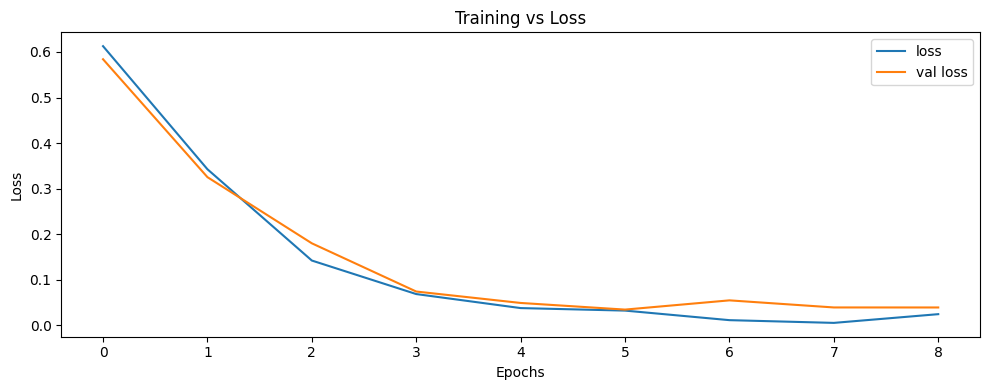

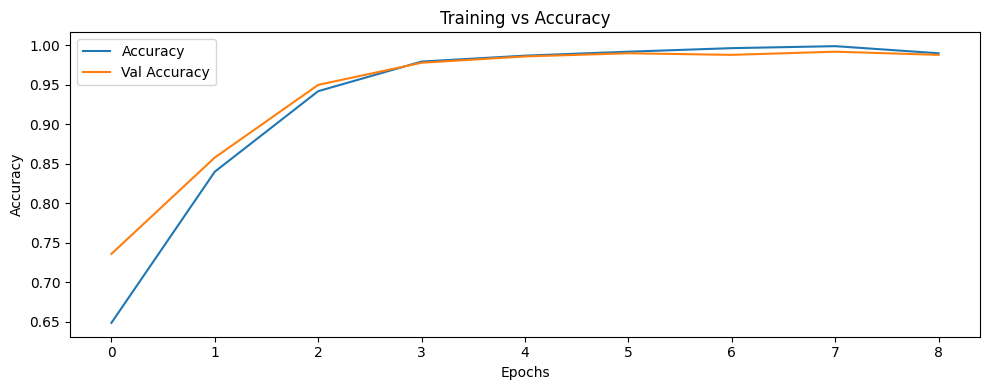

In [ ]:
def plot_accuracy(history):
  plt.figure(figsize=(10, 4))
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training vs Loss")
  plt.tight_layout()
  plt.legend()

  plt.figure(figsize=(10, 4))
  plt.plot(history.history["accuracy"], label="Accuracy")
  plt.plot(history.history["val_accuracy"], label="Val Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training vs Accuracy")
  plt.tight_layout()
  plt.legend()

  plt.show()
  return

plot_accuracy(hist)

In [ ]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks")
current_directory = os.getcwd()
print(current_directory)

/content/drive/MyDrive/Colab Notebooks


In [ ]:
model.save("My_CNN_Model")

# Preparing Data For Pre-Trained Model



In [ ]:
#Preparing data for Pre Trained Model

from numpy.core.multiarray import dtype
import numpy as np

x_train = np.array([], dtype=np.float32)
y_train = np.array([], dtype=np.float32)

for features, label in train_ds:
  x_train = np.append(x_train, features.numpy())
  y_train = np.append(y_train, label.numpy())

x_test = np.array([], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

for features, label in test_ds:
  x_test = np.append(x_test, features.numpy())
  y_test = np.append(y_test, label.numpy())


x_train = x_train.reshape(-1, image_size, image_size, 1).astype(np.float32)
x_test = x_test.reshape(-1, image_size, image_size, 1).astype(np.float32)

x_train = np.repeat(x_train, 3, axis=3).astype(np.float32)
x_test = np.repeat(x_test, 3, axis=3).astype(np.float32)

In [ ]:
x_train.shape

(2001, 224, 224, 3)

In [ ]:
def data_preprocess(x_train, y_train, x_test, y_test):
  x_train = tf.cast(x_train, tf.float32)
  x_test = tf.cast(x_test, tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_ds = train_ds.batch(16)
  train_ds = train_ds.map(lambda x, y: (float(x)/255.0, y))
  train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  test_ds = test_ds.batch(16)
  test_ds = test_ds.map(lambda x, y: (float(x)/255.0, y))
  test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_ds, test_ds

train_ds, test_ds = data_preprocess(x_train, y_train, x_test, y_test)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# VGG19 Pre Trained Model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping

class VGG:
    def __init__(self):
        self.base_model = VGG19(weights="imagenet", include_top=False)

        for layer in self.base_model.layers:
          layer.trainable = False

        x = self.base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(0.01))(x)
        x = Dropout(0.2)(x)
        x = Dense(units=256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(0.01))(x)
        x = Dropout(0.2)(x)
        output = Dense(units=1, activation="sigmoid")(x)

        self.pre_trained_model = Model(inputs=self.base_model.input, outputs=output)
        self.early_stopping = EarlyStopping(patience=3, monitor="val_loss")

    def summary(self):
        return self.base_model.summary()

    def compile(self):
      self.pre_trained_model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=["accuracy"]
          )

    def train(self, train_ds, test_ds, epochs):
      history = self.pre_trained_model.fit(
          train_ds,
          validation_data=test_ds,
          epochs=epochs, callbacks=[self.early_stopping]
          )

      return history

model = VGG()
model.summary()
model.compile()
history = model.train(train_ds, test_ds, epochs=100)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

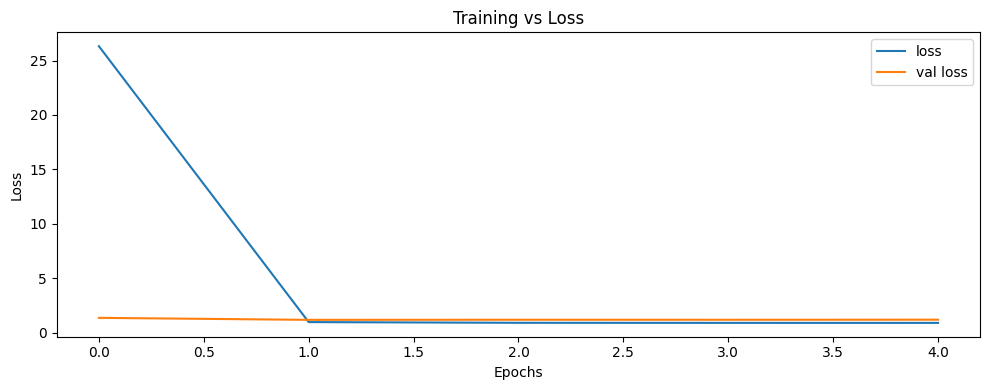

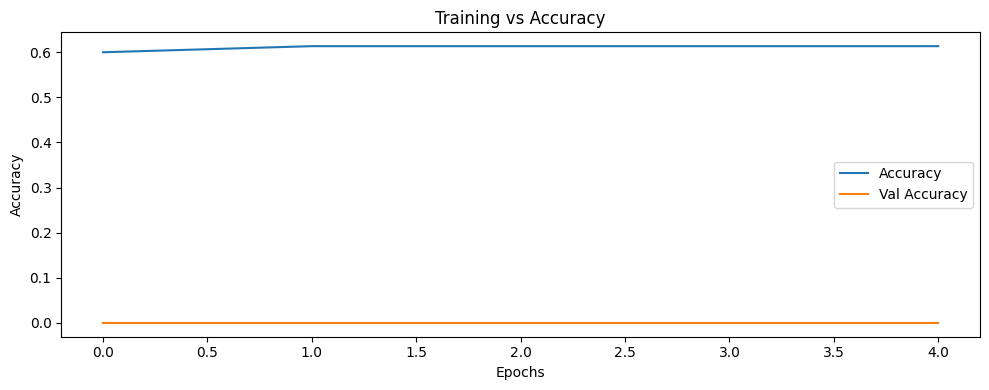

In [ ]:
plot_accuracy(history)

# ResNet50 Pre Trained Model

In [ ]:
from tensorflow.keras.applications import ResNet50

class ResNet(VGG):
  def __init__(self):
    super().__init__()
    self.base_model = ResNet50(weights="imagenet", include_top=False)


model = ResNet()
model.summary()
model.compile()
history = model.train(train_ds, test_ds, epochs=100)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_17[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

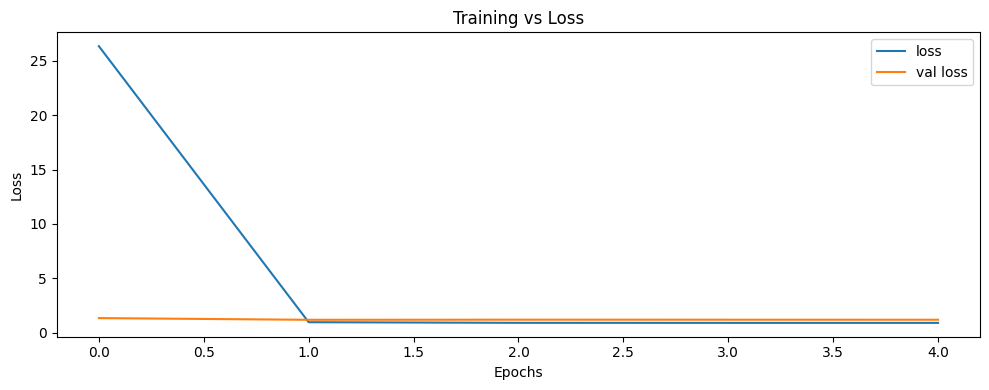

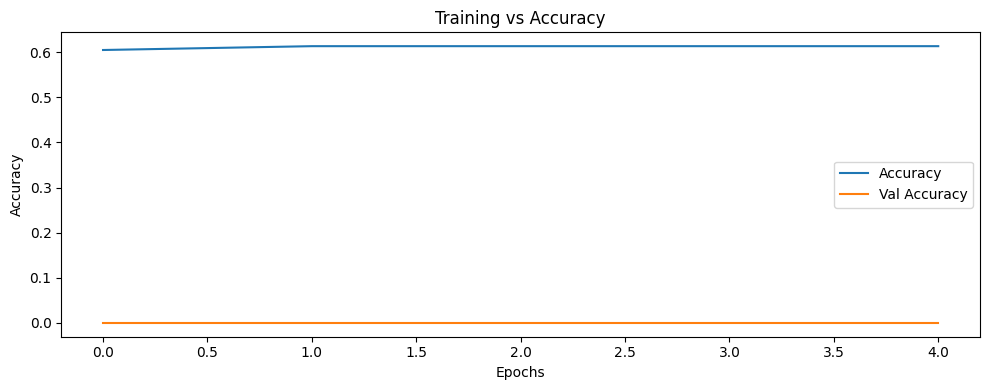

In [ ]:
plot_accuracy(history)

# SVM Model

In [9]:
x_train = np.array([], dtype=np.float32)
y_train = np.array([], dtype=np.float32)

for features, label in train_ds:
  x_train = np.append(x_train, features.numpy())
  y_train = np.append(y_train, label.numpy())

x_test = np.array([], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

for features, label in test_ds:
  x_test = np.append(x_test, features.numpy())
  y_test = np.append(y_test, label.numpy())


x_train = x_train.reshape(-1, image_size, image_size, 1)
x_test = x_test.reshape(-1, image_size, image_size, 1)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [ ]:
x_train.shape

(2001, 50176)

In [ ]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

SVC()

Accuracy Score 0.88
Classification Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.88      0.94       500

    accuracy                           0.88       500
   macro avg       0.50      0.44      0.47       500
weighted avg       1.00      0.88      0.94       500



[]

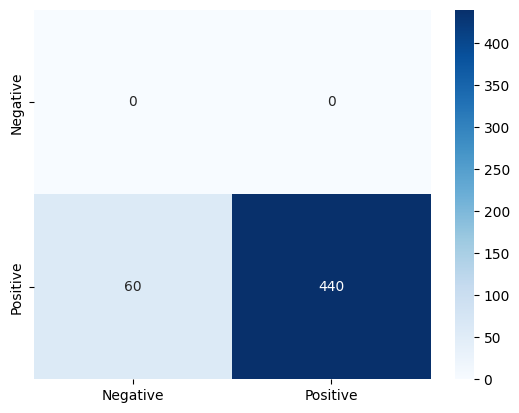

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy Score {accuracy}")
print(f"Classification Report \n{class_report}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.plot()

# KNN Model

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=2,
)

knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)

Accuracy Score 0.916
Classification Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96       500

    accuracy                           0.92       500
   macro avg       0.50      0.46      0.48       500
weighted avg       1.00      0.92      0.96       500



[]

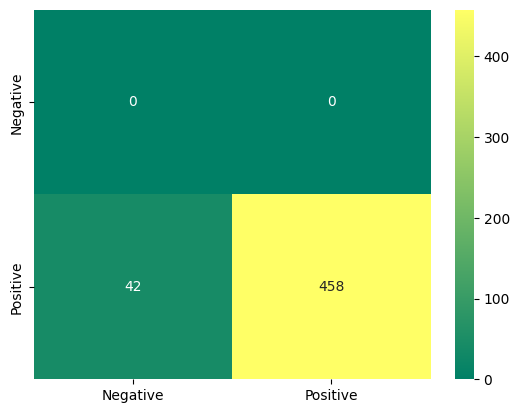

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy Score {accuracy}")
print(f"Classification Report \n{class_report}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="summer", fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.plot()

# Image Input Function

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

def get_image_prediction(image_path, model):
    image_size = 224
    image = load_img(image_path, color_mode='grayscale', target_size=(image_size, image_size), interpolation='bilinear')
    image = img_to_array(image) / 255.0
    image = resize(image, [image_size, image_size])
    image = tf.expand_dims(image, axis=0)

    prediction = model.predict(image)

    if prediction[0, 0] > 0.5:
        return "Stroke"
    else:
        return "Normal"

data_directory = ""
result = get_image_prediction(data_directory, model)
print("Predicted Class:", result)